In [43]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
import time
import uncertainties
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main()

In [4]:
# monitor detector
monitor_data = load_monitor()

In [5]:
# 2 second proton beam current
p_beam_2s = load_p_beam_2s()

In [6]:
# 10 second proton beam current
p_beam_10s = load_p_beam_10s()

# Transmission

Transmission is calculated by comparing the counts from a run, in any guided configuration, to that of the corresponding guide-less configuration. Every run is normalized according to increasing losses within the source volume, attributed to $s_{D_2}$ frost build-up. Explicitly, transmission is calculated as

$$\large{T = \frac{N^\mathrm{guide}}{N^\mathrm{norm}}}$$

where $N^\mathrm{norm}$ is the number of counts in the appropriate normalization configuration. The value used is the average of all the runs carried out in said configuration, after the separate normalization per $s_{D_2}$ losses. There are $3 \times 2$ relevant values for $N^\mathrm{norm}$, for the three pre-storage times (5, 20, 100 seconds) and the two normalization configurations (TRIUMF-style and JP-style).



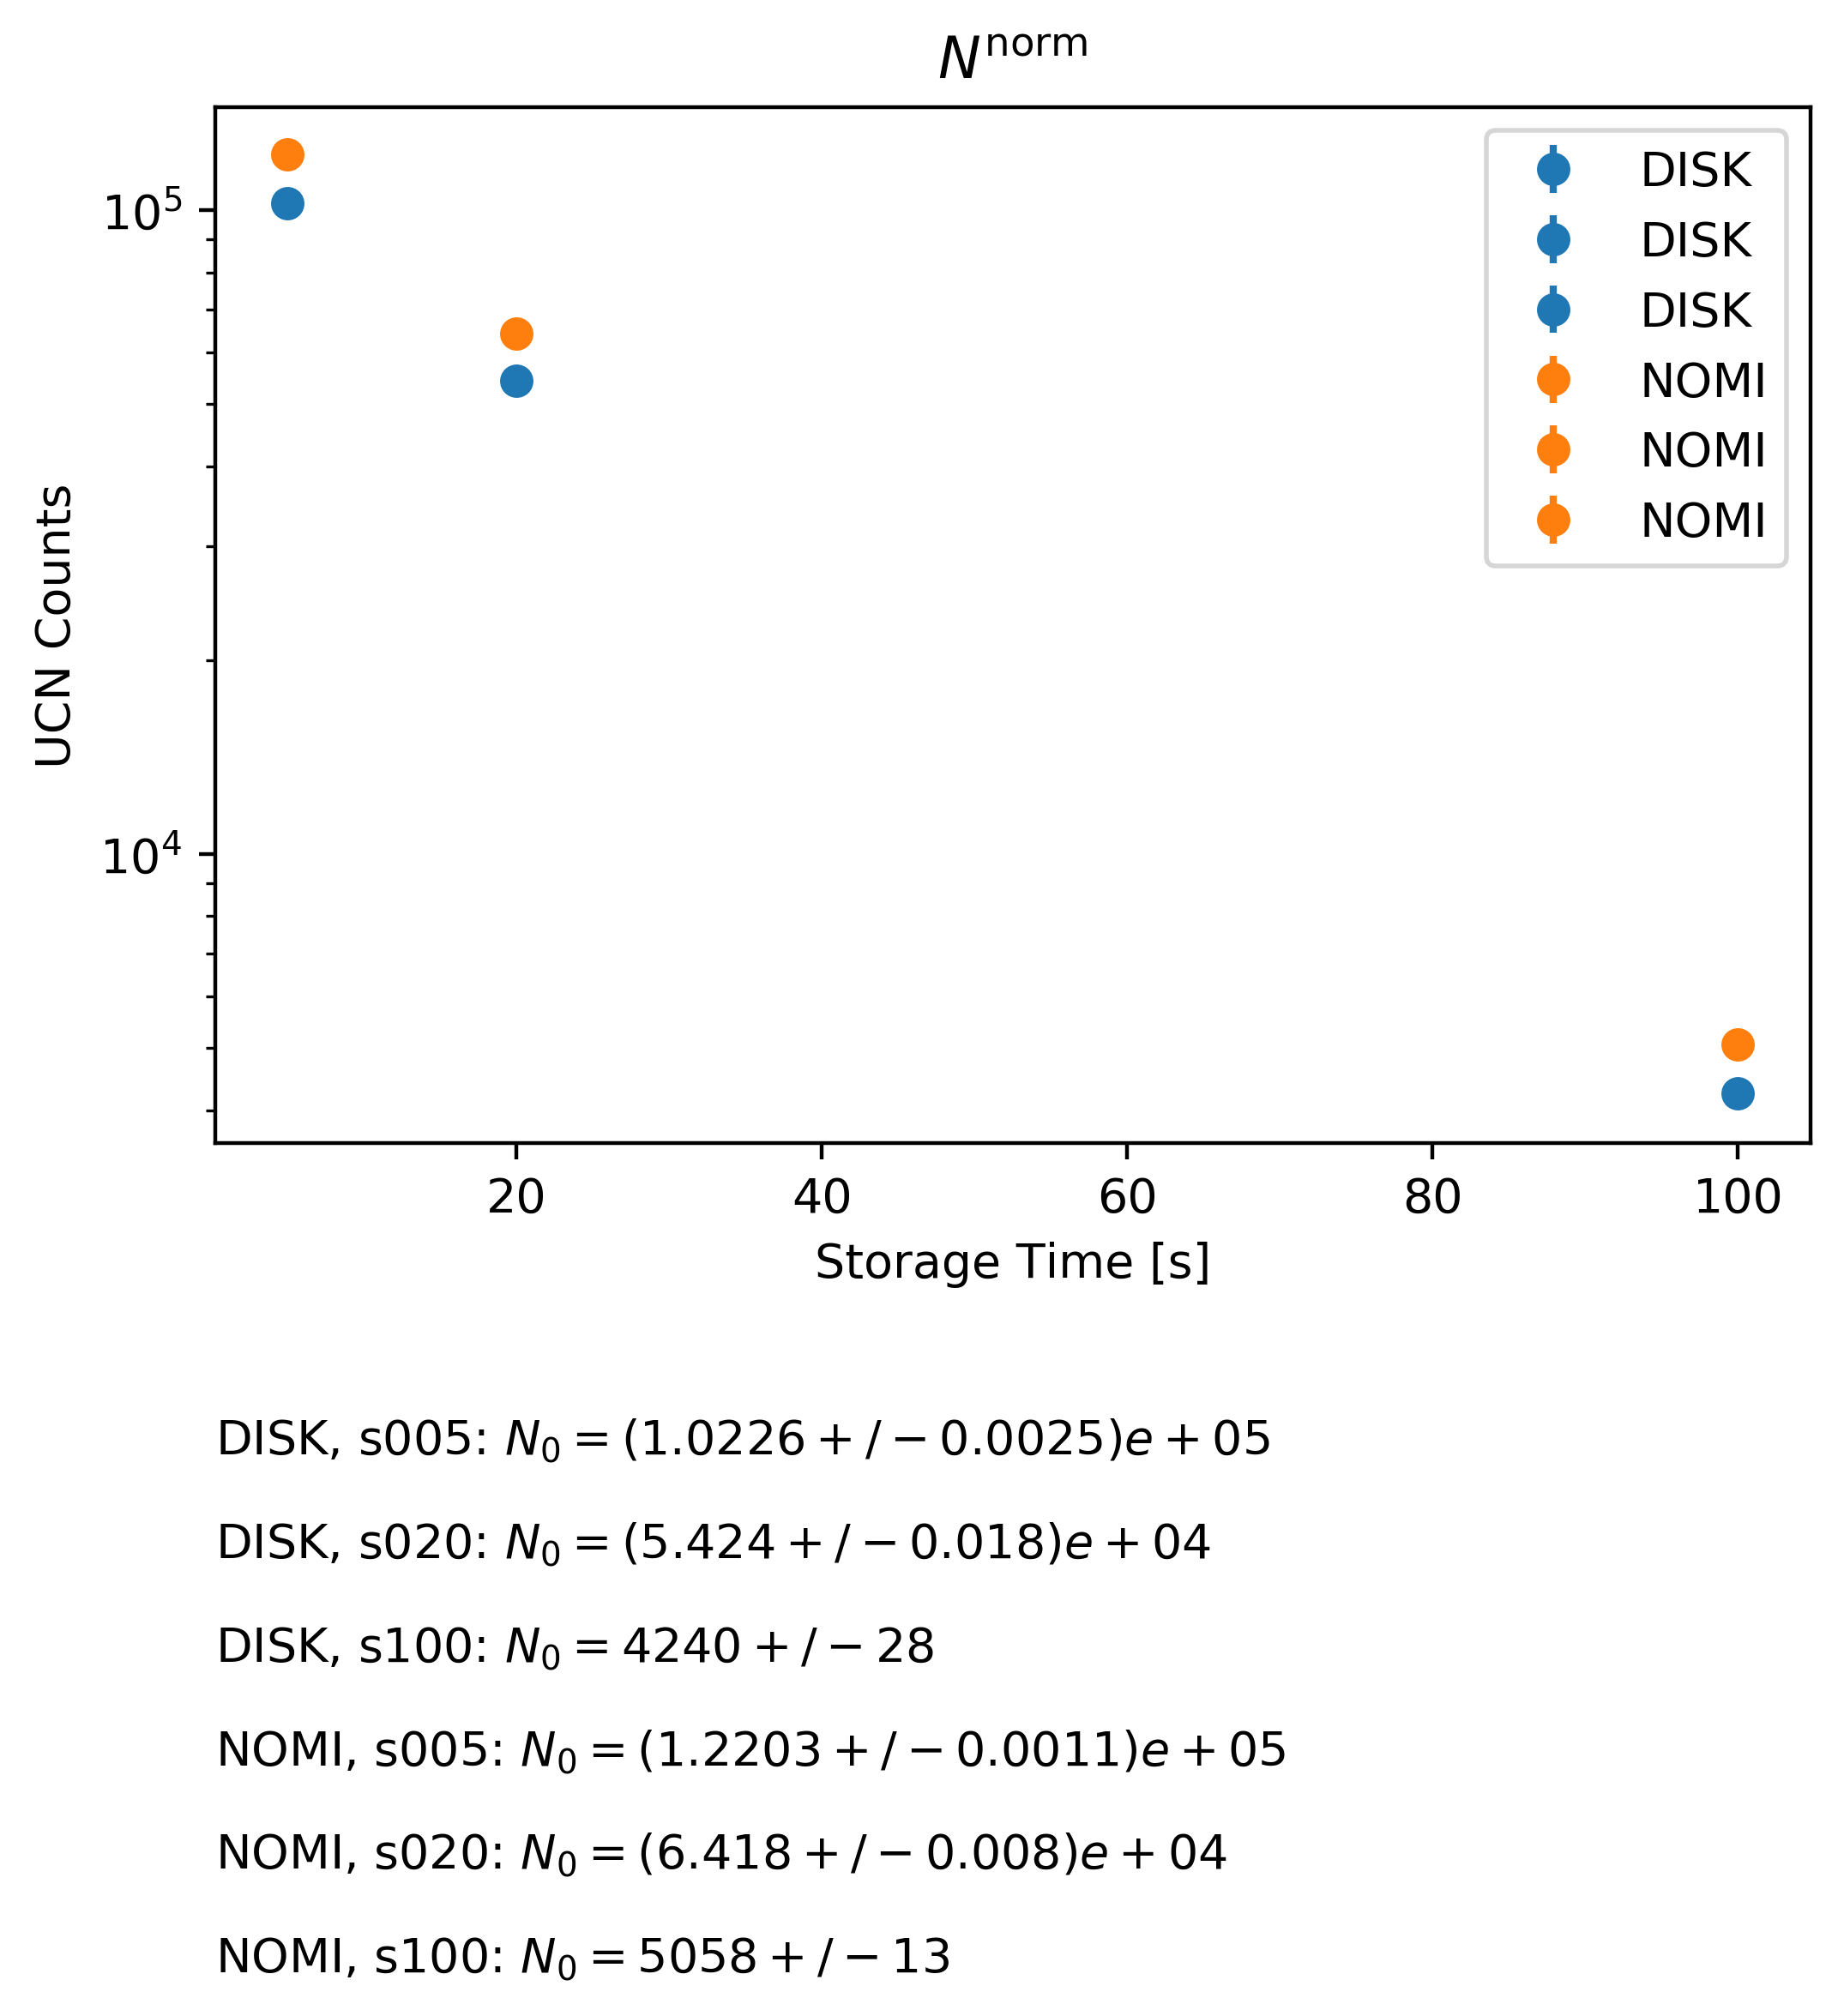

In [63]:
# will generate, and plot, a dictionary of N^norm values as necessary
N_norm_dict   = {} 
fig, ax = plt.subplots()
ax = plt.gca()

i = 0
for config in ['DISK', 'NOMI']:
    
    color = next(ax._get_lines.prop_cycler)['color']
        
    for run_type in ['s005', 's020', 's100']:
        
        # get tha appropriate data set
        arr = data_dict[config, run_type]
        
        # generate uncertainty array of data set, calculate mean, add to dict
        uarr = unumpy.umatrix(arr[:,2], arr[:,3])
        N_norm = uarr.mean(1)[0,0]
        N_norm_dict[config, run_type] = N_norm
        
        # plot
        storage_time = arr[0,1]
        ax.errorbar(storage_time, N_norm.nominal_value, yerr = N_norm.std_dev, 
                    fmt = 'o', label = config, color = color)
        
        # printing the results below the figure
        param_str = config + ', ' + run_type + r': $N_0 = {}$'
        i = i - 0.1
        ax.text(0, -0.2 + i, param_str.format(N_norm),
                                            transform = ax.transAxes);


# presentation stuff
ax.set_yscale('log')
ax.set_xlabel('Storage Time [s]');
# ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_ylabel('UCN Counts');
ax.legend();
ax.set_title(r'$N^\mathrm{norm}$');

Error in transmission is simply propagated as:

\begin{align} 
\frac{\delta T}{T} = \sqrt{\left (\frac{\delta N^\mathrm{guide}}{N^\mathrm{guide}} \right )^2 + \left (\frac{\delta N^\mathrm{norm}}{N^\mathrm{norm}} \right )^2}
\end{align}

The various runs carried out using the same configuration and pre-storage time, are averaged, and the error in the average is propagated as

\begin{align} 
\delta T_\mathrm{ave} = \frac{1}{N}\sqrt{\sum_{i=1}^N \left(\delta T_i\right)^2}
\end{align}

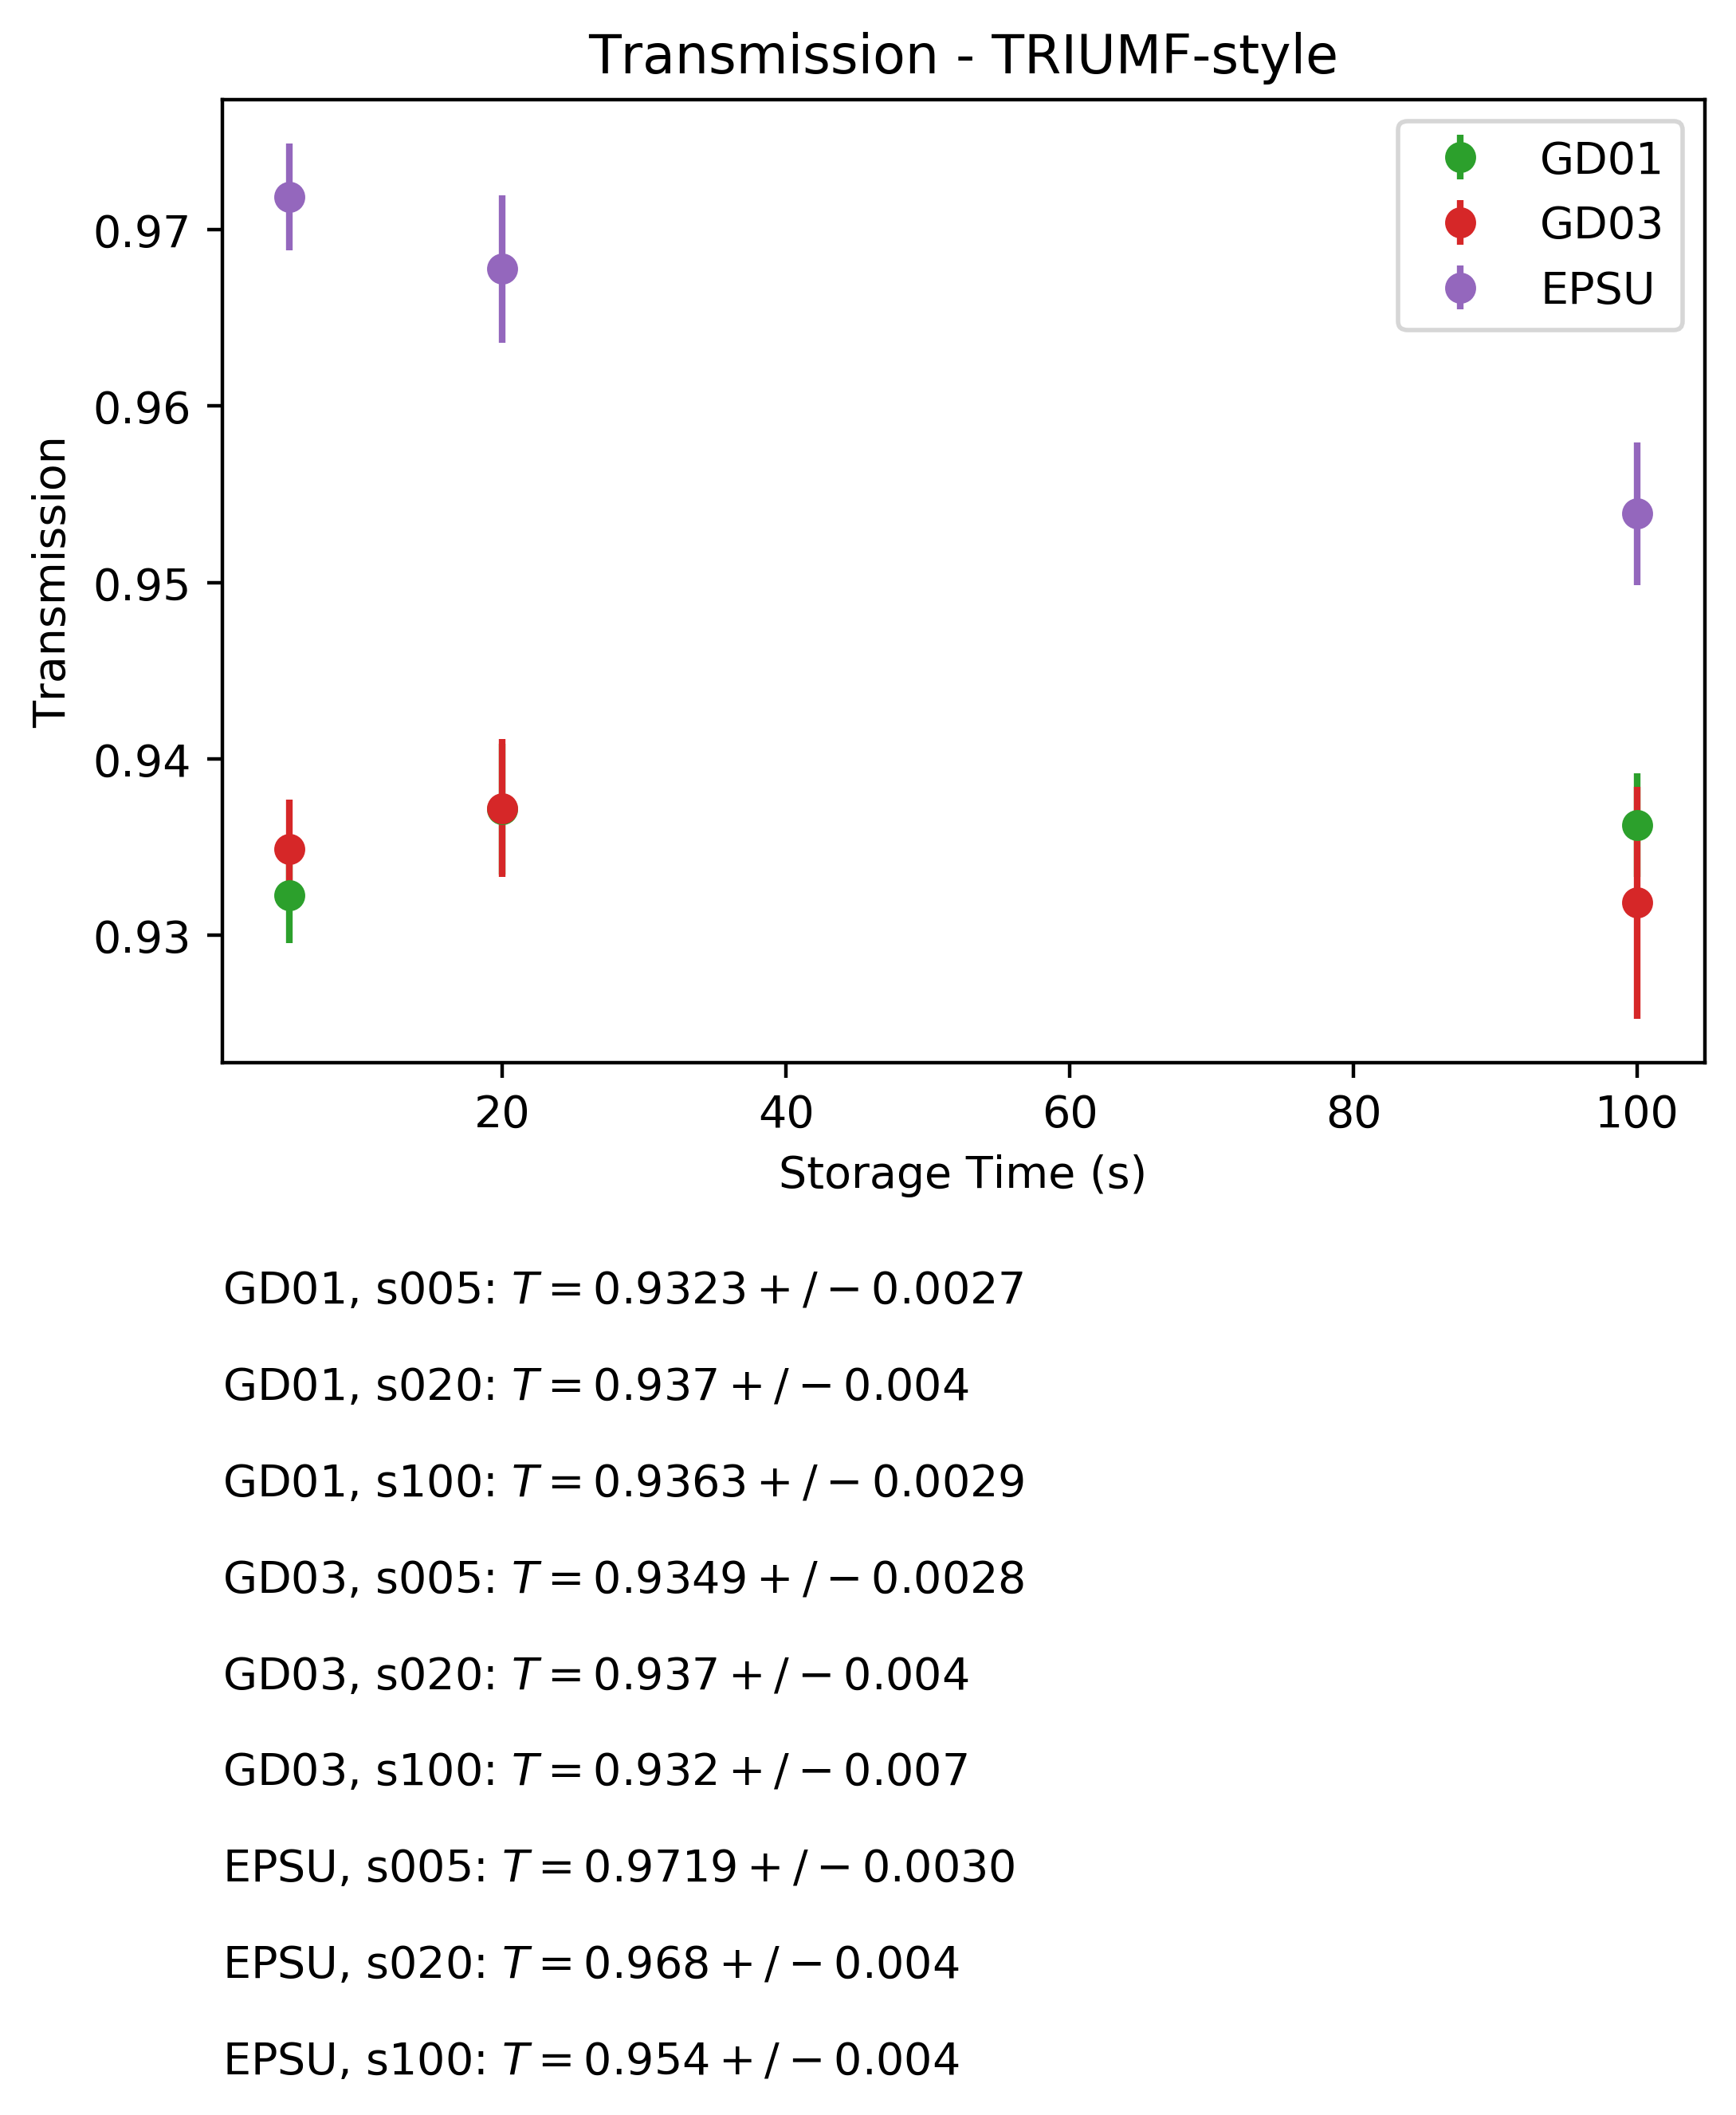

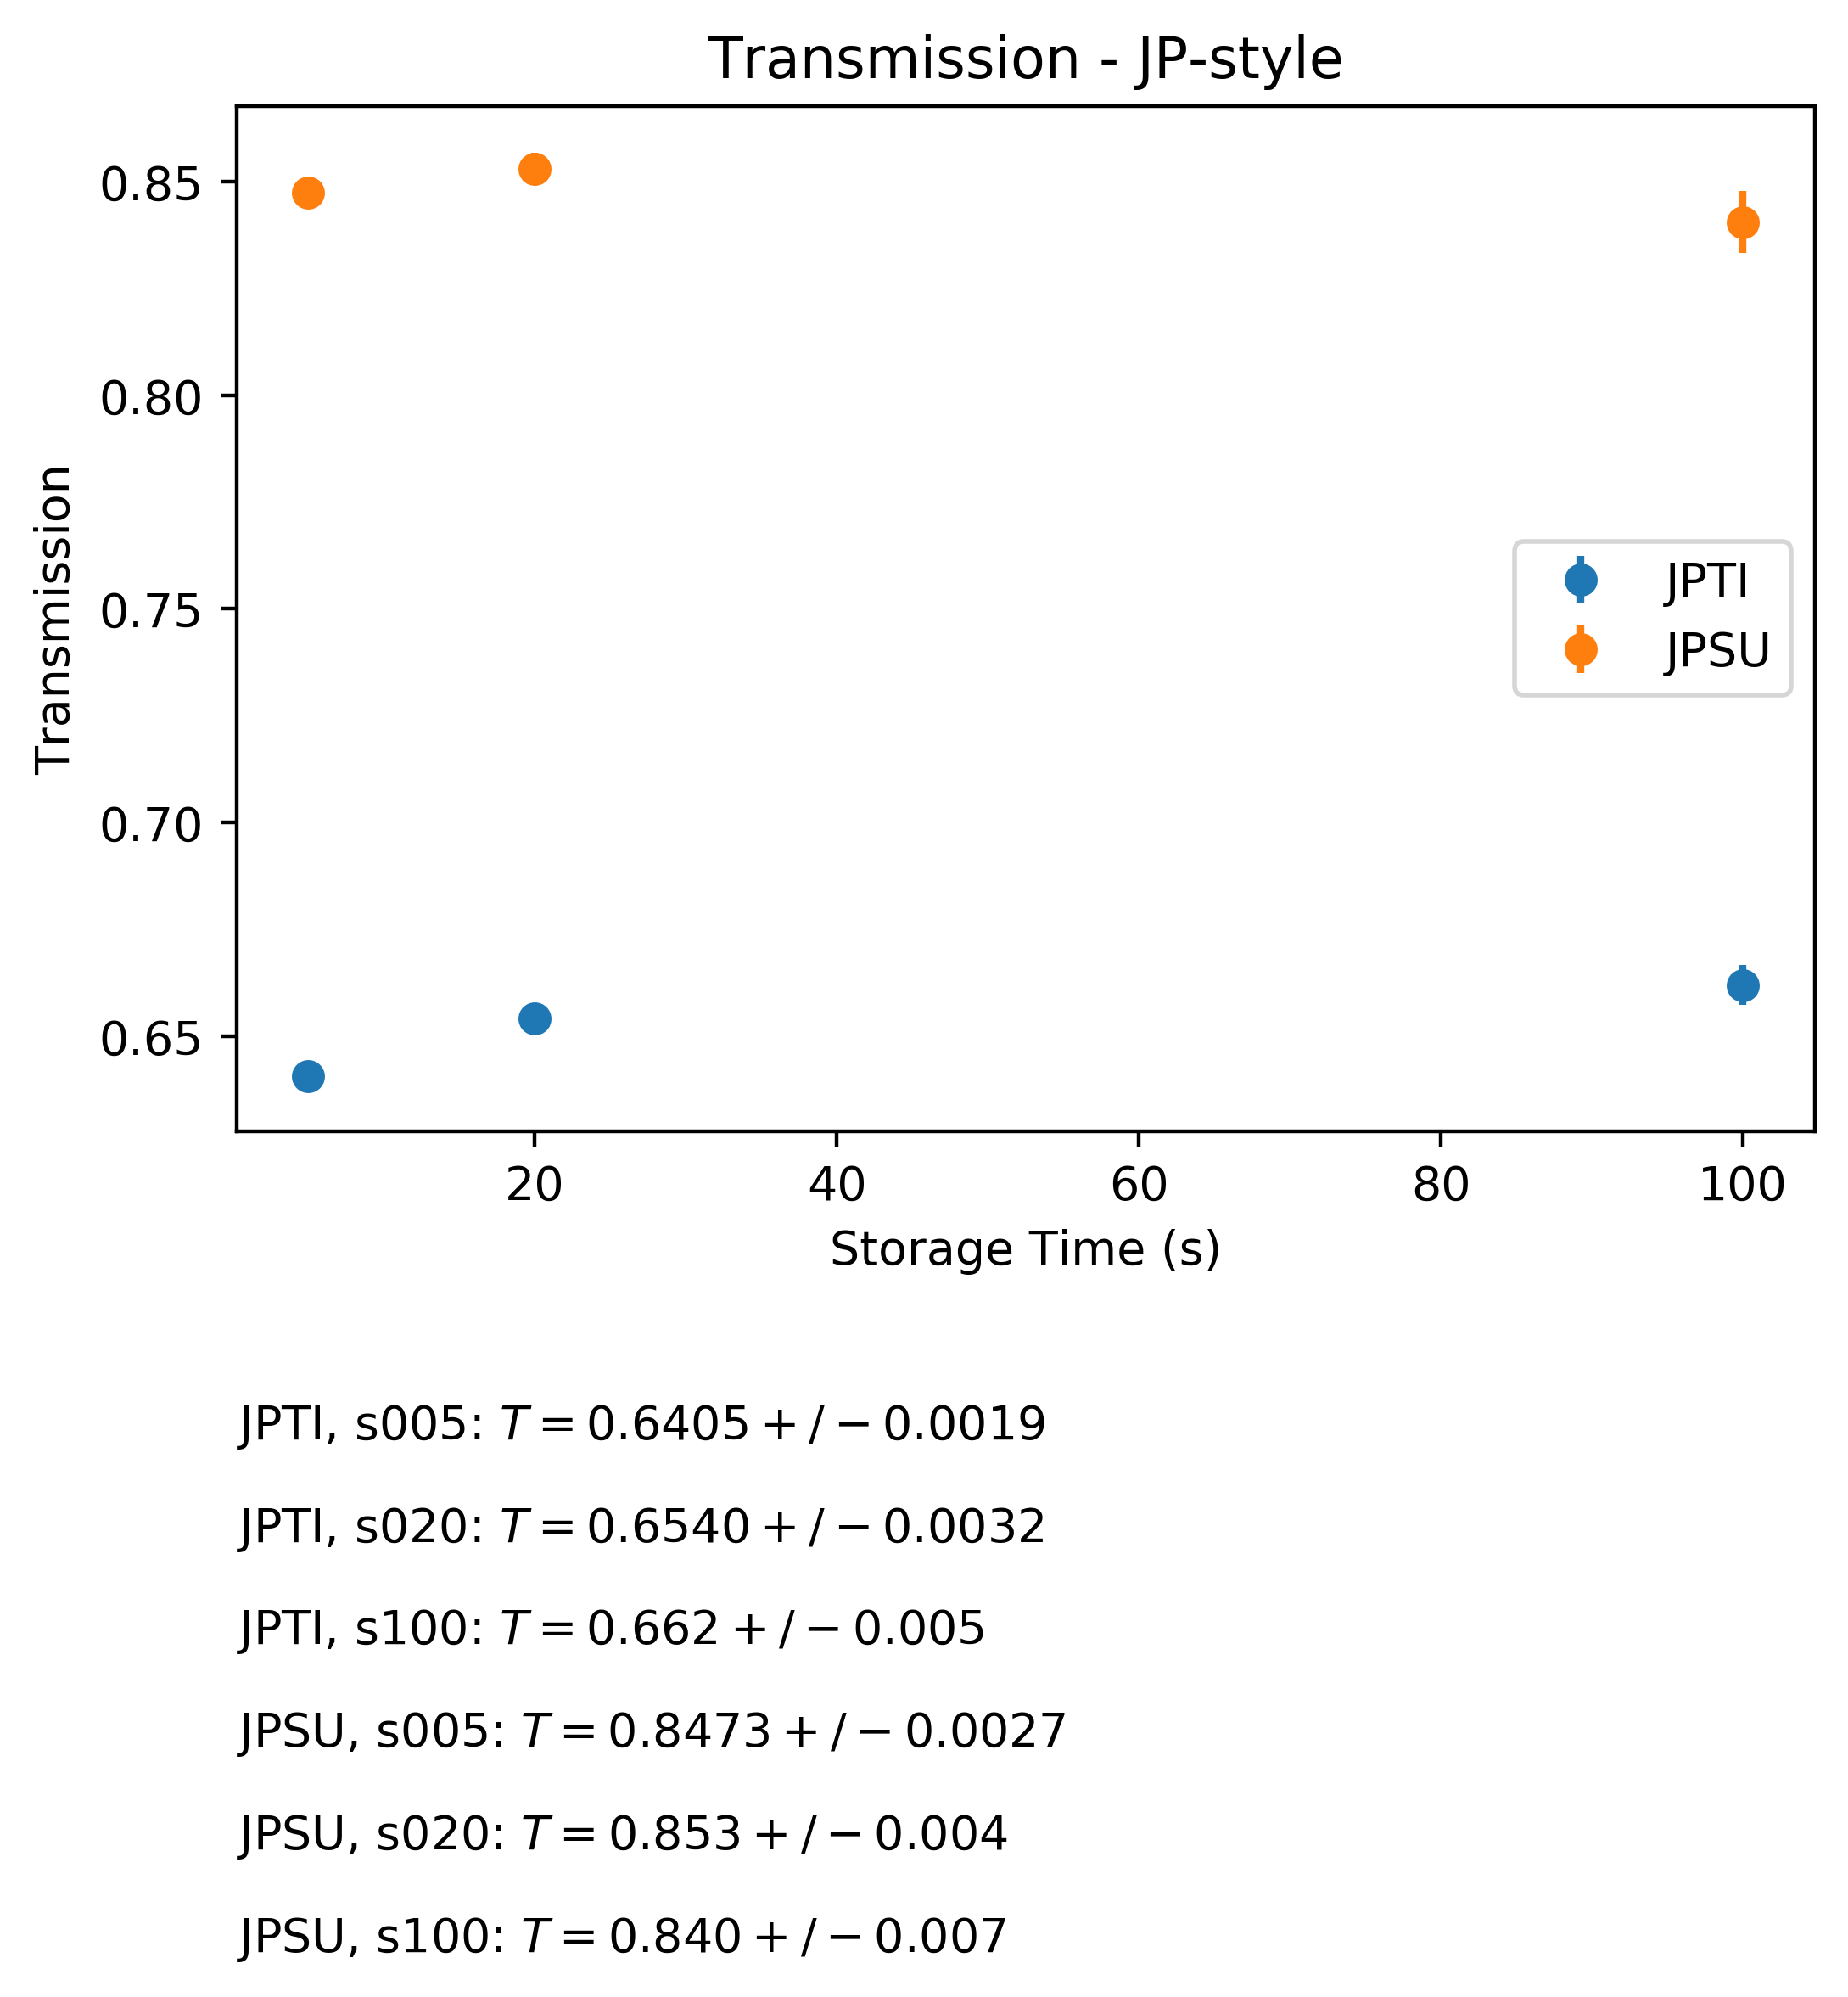

In [64]:
# will generate, and plot, a dictionary of transmission values
# separate figures for TRIUMF and JP styles
t_dict   = {} 
fig_t, ax_t = plt.subplots()
fig_j, ax_j = plt.subplots()
ax_j = plt.gca()

# iterator for text print out formatting
i = 0

for config in ['JPTI', 'JPSU', 'GD01', 'GD03', 'EPSU']:
    
    # update the plotting color
    color = next(ax_j._get_lines.prop_cycler)['color']
    
    for run_type in ['s005', 's020', 's100']:
        
        # get data set
        arr = data_dict[config, run_type]
        
        # generate uncertainty array of data set, calculate mean, add to dict
        uarr = unumpy.umatrix(arr[:,2], arr[:,3])
        N_guide = uarr.mean(1)[0,0]
        
        # iterate for text print-out formatting
        i = i - 0.1
        
        # JP-style
        if (config[0:2] == 'JP'):
            
            # compute, save to dict, and plot transmission
            t = N_guide / N_norm_dict['DISK', run_type]
            t_dict[config, run_type] = t
            storage_time = arr[0,1]
            ax_j.errorbar(storage_time, t.nominal_value, yerr = t.std_dev, 
                          fmt = 'o', label = config, color = color)
            
            # printing the results below the figure
            param_str = config + ', ' + run_type + r': $T = {}$'
            ax_j.text(0, -0.2 + i, param_str.format(t),
                                                transform = ax_j.transAxes);
        
        # TRIUMF-style
        else:
            
            # compute, save to dict, and plot transmission
            t = N_guide / N_norm_dict['NOMI', run_type]
            t_dict[config, run_type] = t
            storage_time = arr[0,1]
            ax_t.errorbar(storage_time, t.nominal_value, yerr = t.std_dev, 
                          fmt = 'o', label = config, color = color)
            
            # printing the results below the figure
            param_str = config + ', ' + run_type + r': $T = {}$'
            ax_t.text(0, 0.45 + i, param_str.format(t),
                                                transform = ax_t.transAxes);
            
# presentation stuff
ax_t.set_title('Transmission - TRIUMF-style')
ax_t.set_ylabel('Transmission');
ax_t.set_xlabel('Storage Time (s)')
ax_t.legend();
handles, labels = ax_t.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax_t.legend(by_label.values(), by_label.keys())

ax_j.set_title('Transmission - JP-style')
ax_j.set_ylabel('Transmission');
ax_j.set_xlabel('Storage Time (s)')
ax_j.legend();
handles, labels = ax_j.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax_j.legend(by_label.values(), by_label.keys());

Next it would be good to plot an averaged transmission value, for each guide across the various storage times. Since these aren't identical measurements, I'll let the error bar be simply be the standard deviation of the three nominal values (thus ignoring the statistical uncertainty propagated forward from the preceeding analysis).

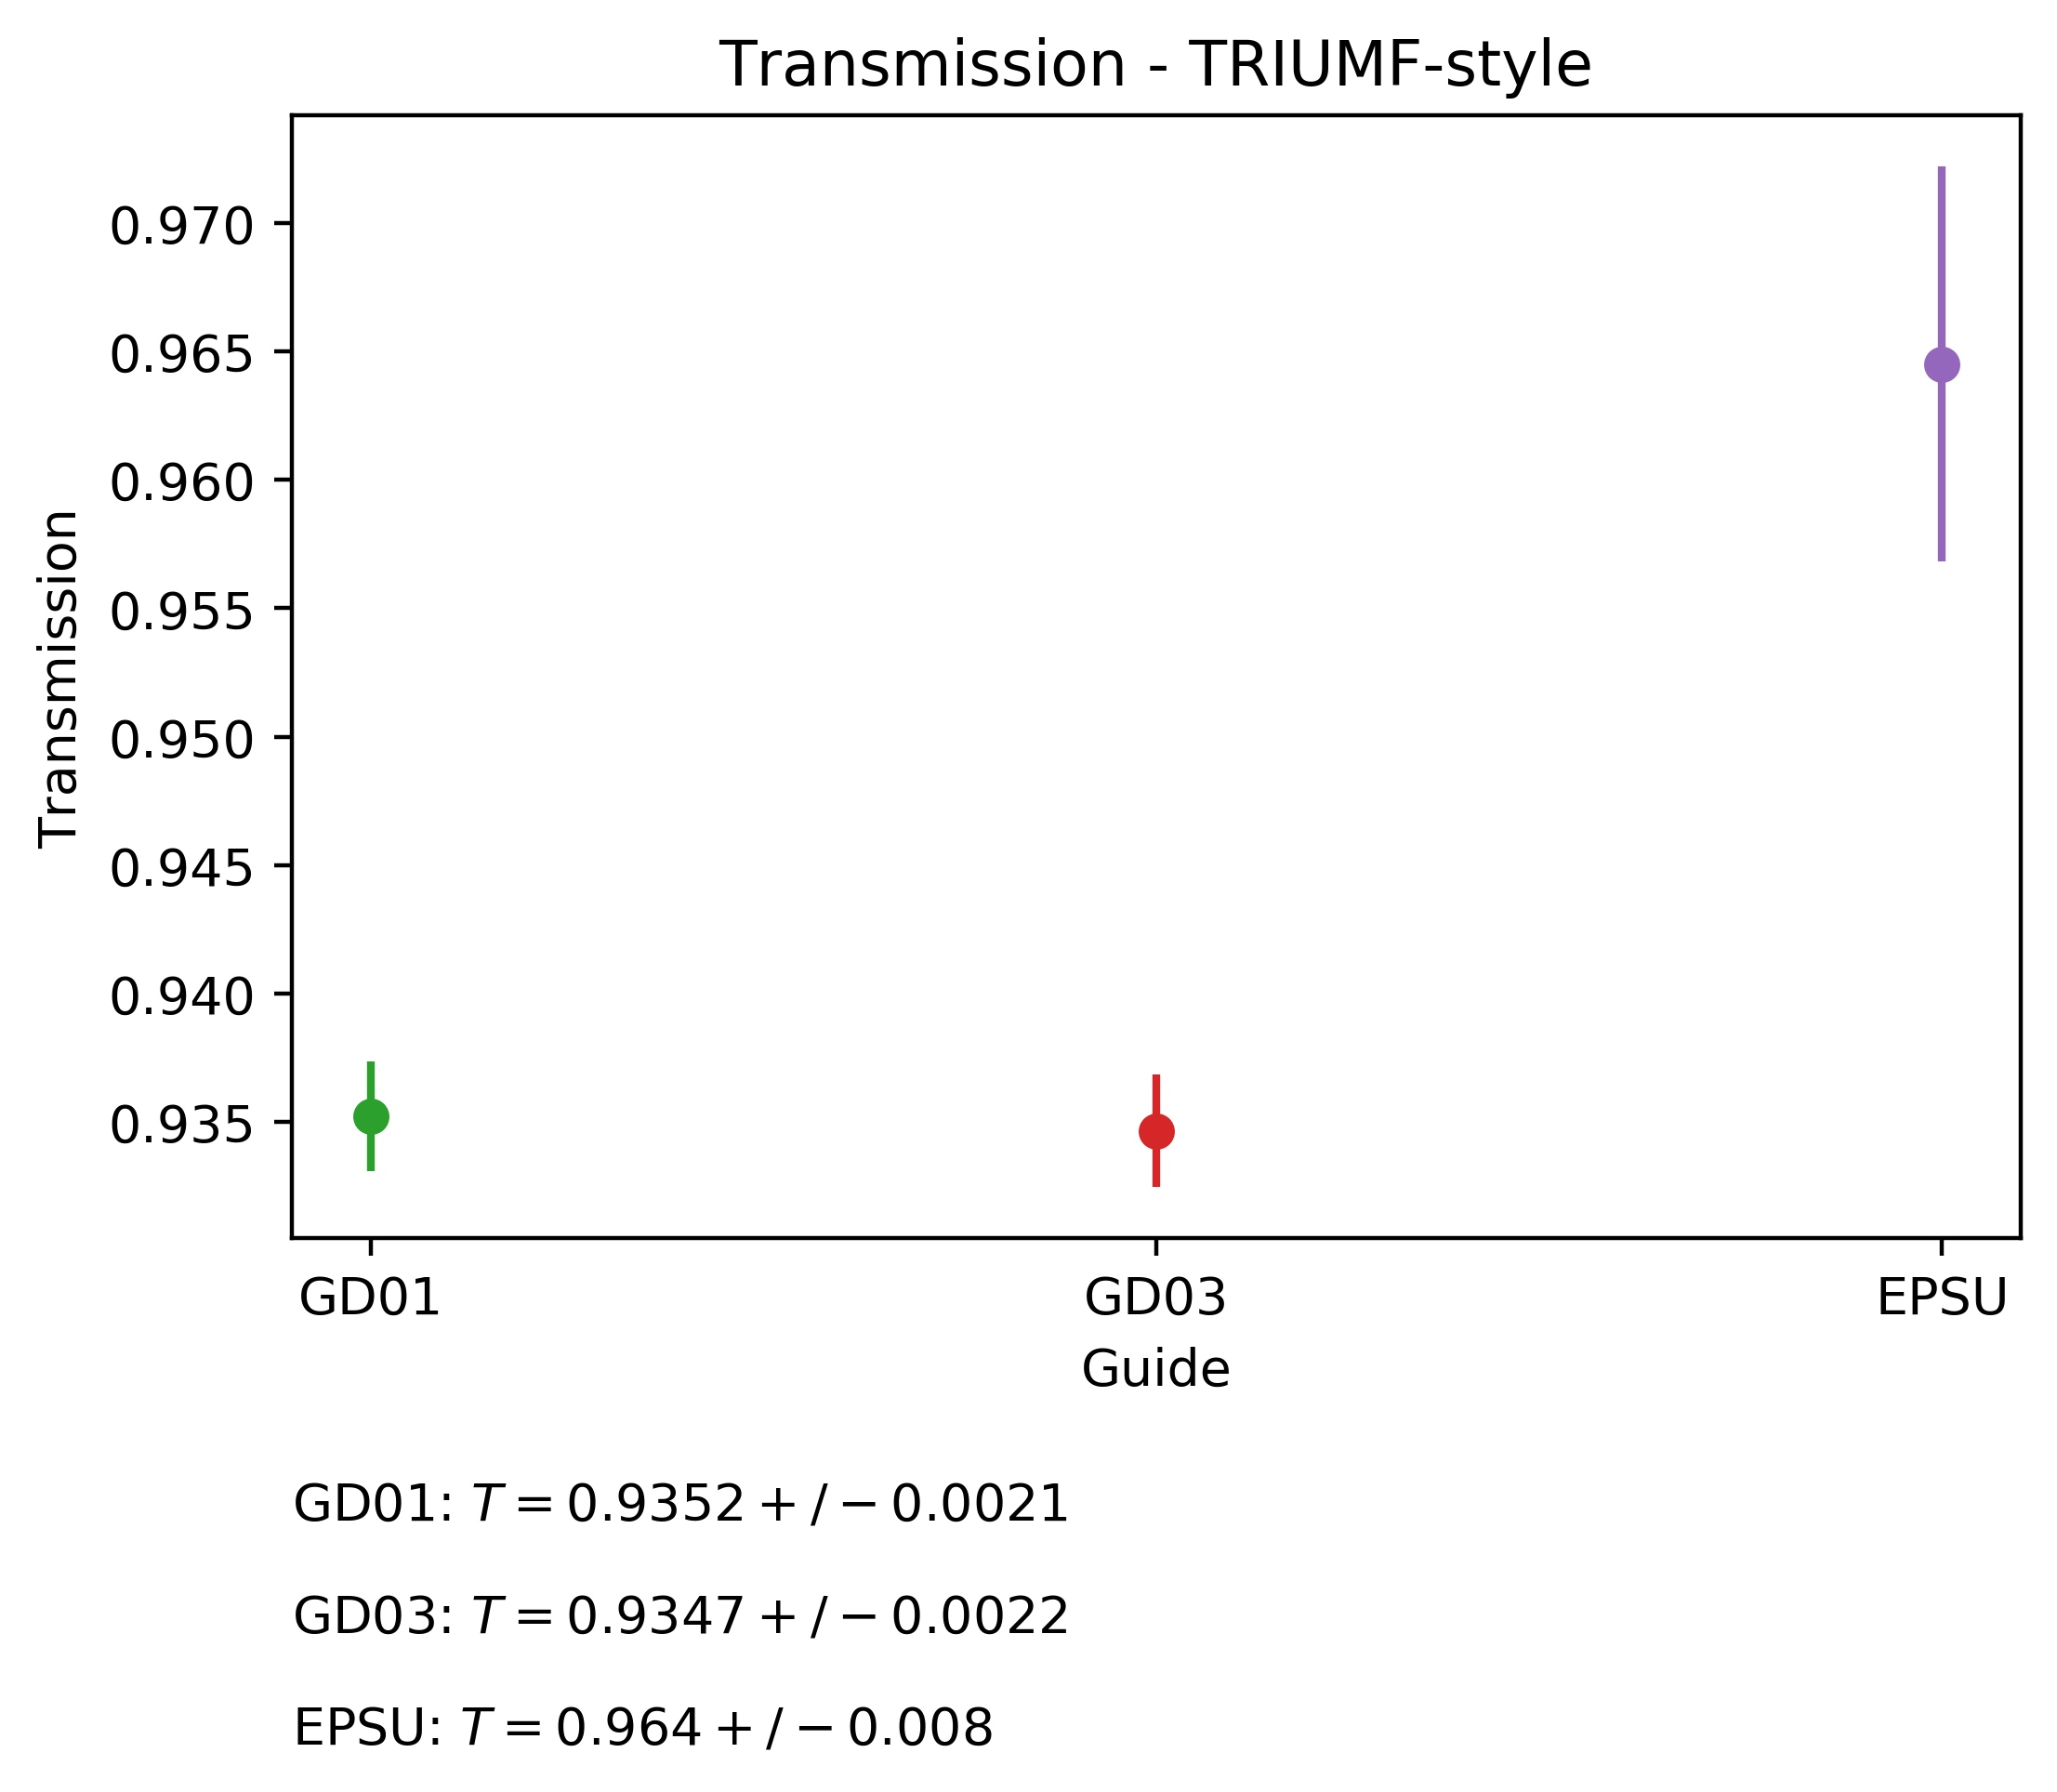

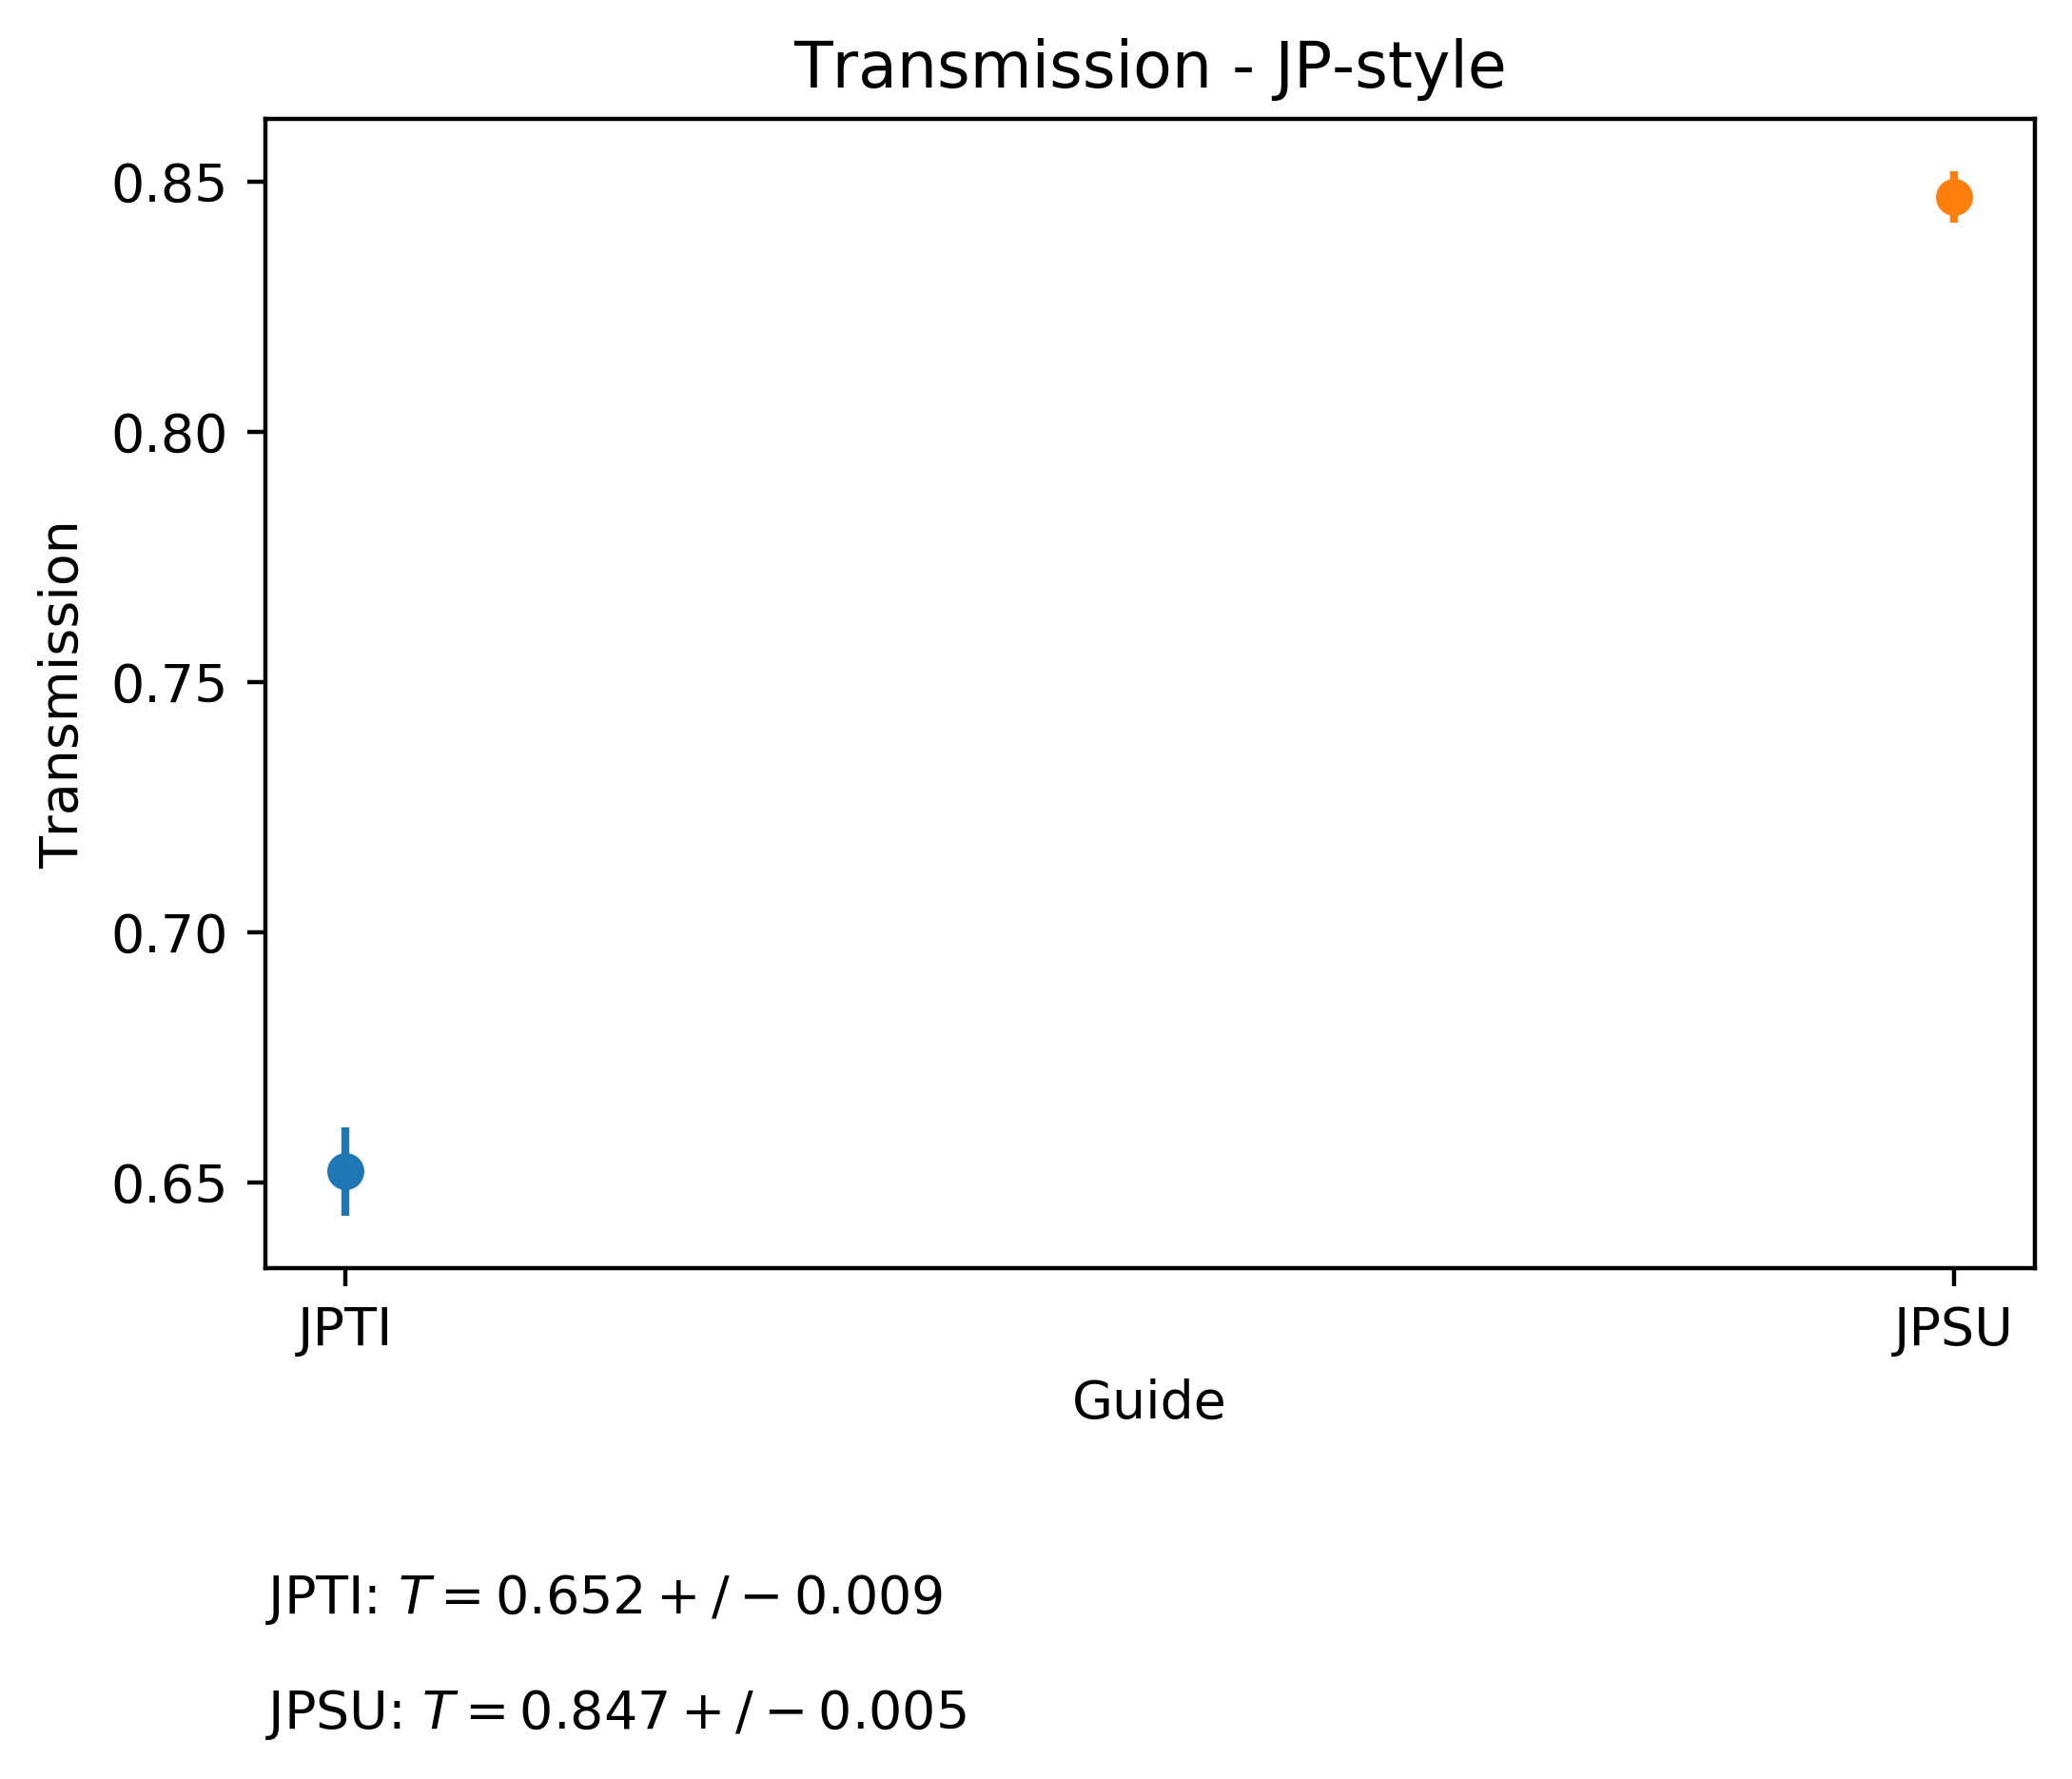

In [86]:
# separate figures for TRIUMF and JP styles
fig_t, ax_t = plt.subplots()
fig_j, ax_j = plt.subplots()
ax_j = plt.gca()

# iterator for text print out formatting
i = 0

for config in ['JPTI', 'JPSU', 'GD01', 'GD03', 'EPSU']:
    
    # update the plotting color
    color = next(ax_j._get_lines.prop_cycler)['color']
    
    t_arr = np.array([t_dict[config, 's005'].nominal_value, 
                      t_dict[config, 's020'].nominal_value,
                      t_dict[config, 's100'].nominal_value])
    
    t_ave = ufloat(np.average(t_arr), np.std(t_arr))

    # iterate for text print-out formatting
    i = i - 0.1

    # JP-style
    if (config[0:2] == 'JP'):

        ax_j.errorbar([config], t_ave.nominal_value, 
                      yerr = t_ave.std_dev, 
                      fmt = 'o', label = config, color = color)

        # printing the results below the figure
        param_str = config + r': $T = {}$'
        ax_j.text(0, -0.2 + i, param_str.format(t_ave),
                                            transform = ax_j.transAxes);

    # TRIUMF-style
    else:

        ax_t.errorbar([config], t_ave.nominal_value, 
                      yerr = t_ave.std_dev, 
                      fmt = 'o', label = config, color = color)

        # printing the results below the figure
        param_str = config + r': $T = {}$'
        ax_t.text(0, 0.05 + i, param_str.format(t_ave),
                                            transform = ax_t.transAxes);

# presentation stuff
ax_t.set_title('Transmission - TRIUMF-style')
ax_t.set_ylabel('Transmission');
ax_t.set_xlabel('Guide')

ax_j.set_title('Transmission - JP-style')
ax_j.set_ylabel('Transmission');
ax_j.set_xlabel('Guide');